In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import arff
import warnings
warnings.filterwarnings('ignore')

# Modelling and Forecasting
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

### Loading and Understanding Data

In [52]:
# Load ARFF file with liac-arff
with open("dataset.arff") as f:
    dataset = arff.load(f)


In [53]:
# Convert to DataFrame
df = pd.DataFrame(dataset['data'], columns=[attr[0] for attr in dataset['attributes']])

In [54]:
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [55]:
df.tail()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
420763,35060,2017,2,28,19,11.0,32.0,3.0,24.0,400.0,72.0,12.5,1013.5,-16.2,0.0,NW,2.4,Wanshouxigong
420764,35061,2017,2,28,20,13.0,32.0,3.0,41.0,500.0,50.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Wanshouxigong
420765,35062,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,0.0,NW,1.1,Wanshouxigong
420766,35063,2017,2,28,22,12.0,23.0,4.0,30.0,400.0,59.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Wanshouxigong
420767,35064,2017,2,28,23,13.0,19.0,4.0,38.0,600.0,49.0,8.6,1014.1,-15.9,0.0,NNE,1.3,Wanshouxigong


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 57.8+ MB


In [57]:
df.isnull().sum()

No             0
year           0
month          0
day            0
hour           0
PM2.5       8739
PM10        6449
SO2         9021
NO2        12116
CO         20701
O3         13277
TEMP         398
PRES         393
DEWP         403
RAIN         390
wd          1822
WSPM         318
station        0
dtype: int64

In [58]:
df.describe()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,412029.000000,414319.000000,411747.000000,408652.000000,400067.000000,407491.000000,420370.000000,420375.000000,420365.000000,420378.000000,420450.000000
mean,17532.500000,2014.662560,6.522930,15.729637,11.500000,79.793428,104.602618,15.830835,50.638586,1230.766454,57.372271,13.538976,1010.746982,2.490822,0.064476,1.729711
std,10122.116943,1.177198,3.448707,8.800102,6.922195,80.822391,91.772426,21.650603,35.127912,1160.182716,56.661607,11.436139,10.474055,13.793847,0.821004,1.246386
min,1.000000,2013.000000,1.000000,1.000000,0.000000,2.000000,2.000000,0.285600,1.026500,100.000000,0.214200,-19.900000,982.400000,-43.400000,0.000000,0.000000
25%,8766.750000,2014.000000,4.000000,8.000000,5.750000,20.000000,36.000000,3.000000,23.000000,500.000000,11.000000,3.100000,1002.300000,-8.900000,0.000000,0.900000
50%,17532.500000,2015.000000,7.000000,16.000000,11.500000,55.000000,82.000000,7.000000,43.000000,900.000000,45.000000,14.500000,1010.400000,3.100000,0.000000,1.400000
75%,26298.250000,2016.000000,10.000000,23.000000,17.250000,111.000000,145.000000,20.000000,71.000000,1500.000000,82.000000,23.300000,1019.000000,15.100000,0.000000,2.200000
max,35064.000000,2017.000000,12.000000,31.000000,23.000000,999.000000,999.000000,500.000000,290.000000,10000.000000,1071.000000,41.600000,1042.800000,29.100000,72.500000,13.200000


In [59]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
No,420768.0,17532.500000,10122.116943,1.0000,8766.75,17532.5,26298.25,35064.0
year,420768.0,2014.662560,1.177198,2013.0000,2014.00,2015.0,2016.00,2017.0
month,420768.0,6.522930,3.448707,1.0000,4.00,7.0,10.00,12.0
day,420768.0,15.729637,8.800102,1.0000,8.00,16.0,23.00,31.0
hour,420768.0,11.500000,6.922195,0.0000,5.75,11.5,17.25,23.0
PM2.5,412029.0,79.793428,80.822391,2.0000,20.00,55.0,111.00,999.0
PM10,414319.0,104.602618,91.772426,2.0000,36.00,82.0,145.00,999.0
SO2,411747.0,15.830835,21.650603,0.2856,3.00,7.0,20.00,500.0
NO2,408652.0,50.638586,35.127912,1.0265,23.00,43.0,71.00,290.0
CO,400067.0,1230.766454,1160.182716,100.0000,500.00,900.0,1500.00,10000.0


### Preprocessing

In [60]:
# Convert datetime first
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('datetime', inplace=True)

In [61]:
# Drop unused columns
df = df.drop(columns=['year', 'month', 'day', 'hour', 'No', 'station'])

In [62]:
# Sort to fix warnings
df = df.sort_index()

In [63]:
# Interpolate small gaps (numeric columns only)
df[df.select_dtypes(include=['number']).columns] = (
    df.select_dtypes(include=['number']).interpolate(method='time', limit=3)
)

# Replace negative pollutant values with NaN
pollutants = ["PM2.5", "PM10", "SO2", "NO2", "CO", "O3"]
for col in pollutants:
    df[col] = df[col].mask(df[col] < 0)

# Fill remaining NaNs in numeric columns with median
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())




In [64]:
df.isnull().sum()

PM2.5       0
PM10        0
SO2         0
NO2         0
CO          0
O3          0
TEMP        0
PRES        0
DEWP        0
RAIN        0
wd       1822
WSPM        0
dtype: int64

In [65]:
df["wd"] = df["wd"].fillna(method="ffill")

In [66]:
df.isnull().sum()

PM2.5    0
PM10     0
SO2      0
NO2      0
CO       0
O3       0
TEMP     0
PRES     0
DEWP     0
RAIN     0
wd       0
WSPM     0
dtype: int64

### Feature engineering

In [67]:
# Time-based features
df['hour'] = df.index.hour
df['month'] = df.index.month
df['weekday'] = df.index.weekday


In [68]:
# Wind direction to degrees
wind_map = {
    "N": 0, "NNE": 22.5, "NE": 45, "ENE": 67.5,
    "E": 90, "ESE": 112.5, "SE": 135, "SSE": 157.5,
    "S": 180, "SSW": 202.5, "SW": 225, "WSW": 247.5,
    "W": 270, "WNW": 292.5, "NW": 315, "NNW": 337.5
}
df['wd'] = df['wd'].map(wind_map)

In [69]:
# Cyclic encoding for wind direction
df['wd_sin'] = np.sin(np.deg2rad(df['wd']))
df['wd_cos'] = np.cos(np.deg2rad(df['wd']))


In [70]:
# Lag features for PM2.5
for lag in [1, 6, 24]:
    df[f'PM2.5_lag{lag}'] = df['PM2.5'].shift(lag)

In [71]:
# Rolling mean (24h)
df['PM2.5_roll_mean'] = df['PM2.5'].rolling(window=24).mean()

In [72]:
# Drop NaNs created by lags/rolling
df = df.dropna()

In [73]:
# Remove any remaining duplicate index labels (keep first)
df = df[~df.index.duplicated(keep="first")]

In [74]:
# Make sure frequency is hourly
df = df.asfreq('H')

In [75]:
df.isnull().sum()

PM2.5              0
PM10               0
SO2                0
NO2                0
CO                 0
O3                 0
TEMP               0
PRES               0
DEWP               0
RAIN               0
wd                 0
WSPM               0
hour               0
month              0
weekday            0
wd_sin             0
wd_cos             0
PM2.5_lag1         0
PM2.5_lag6         0
PM2.5_lag24        0
PM2.5_roll_mean    0
dtype: int64

In [76]:
df.describe()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,WSPM,hour,month,weekday,wd_sin,wd_cos,PM2.5_lag1,PM2.5_lag6,PM2.5_lag24,PM2.5_roll_mean
count,35062.000000,35062.000000,35062.000000,35062.000000,35062.000000,35062.000000,35062.000000,35062.000000,35062.000000,35062.000000,...,35062.00000,35062.000000,35062.000000,35062.000000,3.506200e+04,35062.000000,35062.000000,35062.000000,35062.000000,35062.000000
mean,79.804169,104.834575,15.882972,50.769560,1235.894187,57.022929,13.543098,1010.752841,2.485276,0.062692,...,1.72825,11.500627,6.523130,3.000627,6.305092e-02,0.111360,79.761731,79.598845,79.803741,79.667373
std,80.848570,91.963613,21.682904,35.312697,1172.148297,56.408565,11.429971,10.478512,13.800885,0.765035,...,1.24813,6.921983,3.448748,2.001269,7.093549e-01,0.693157,80.817706,80.739208,80.848942,75.741880
min,3.000000,2.000000,0.285600,1.026500,100.000000,0.214200,-16.900000,982.700000,-35.300000,0.000000,...,0.00000,0.000000,1.000000,0.000000,-1.000000e+00,-1.000000,2.000000,2.000000,3.000000,3.416667
25%,21.000000,36.000000,3.000000,23.000000,500.000000,10.763550,3.100000,1002.300000,-9.000000,0.000000,...,0.90000,6.000000,4.000000,1.000000,-7.071068e-01,-0.707107,20.000000,21.000000,21.000000,23.166667
50%,55.000000,82.000000,7.000000,43.000000,900.000000,44.125200,14.500000,1010.400000,3.100000,0.000000,...,1.40000,12.000000,7.000000,3.000000,1.224647e-16,0.382683,55.000000,55.000000,55.000000,57.750000
75%,111.000000,145.000000,20.000000,71.000000,1500.000000,82.000000,23.200000,1019.000000,15.100000,0.000000,...,2.20000,17.750000,10.000000,5.000000,7.071068e-01,0.707107,111.000000,111.000000,111.000000,108.875000
max,898.000000,957.000000,341.000000,271.000000,10000.000000,1071.000000,41.600000,1042.300000,29.000000,40.700000,...,13.20000,23.000000,12.000000,6.000000,1.000000e+00,1.000000,941.000000,844.000000,898.000000,691.083333


### Train-Test Split (explicit dates)

In [77]:
train = df.loc["2013-03-01":"2015-12-31"]
test  = df.loc["2016-01-01":"2017-02-28"]

In [78]:
print("Training set:", train.shape, "Period:", train.index.min(), "→", train.index.max())
print("Testing set:", test.shape, "Period:", test.index.min(), "→", test.index.max())

Training set: (24862, 21) Period: 2013-03-01 02:00:00 → 2015-12-31 23:00:00
Testing set: (10200, 21) Period: 2016-01-01 00:00:00 → 2017-02-28 23:00:00


In [79]:
# Define target (PM2.5) 
y_train = train['PM2.5']
X_train = train.drop(columns=['PM2.5'])

y_test = test['PM2.5']
X_test = test.drop(columns=['PM2.5'])

### Stationarity check (ADF test)

In [80]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"ADF Test for {title}")
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("Stationary")
    else:
        print(" Non-stationary")

adf_test(y_train, "PM2.5 (Training set)")


ADF Test for PM2.5 (Training set)
ADF Statistic: -16.45362045966664
p-value: 2.365705672627876e-29
Stationary


### Seasonality visualization

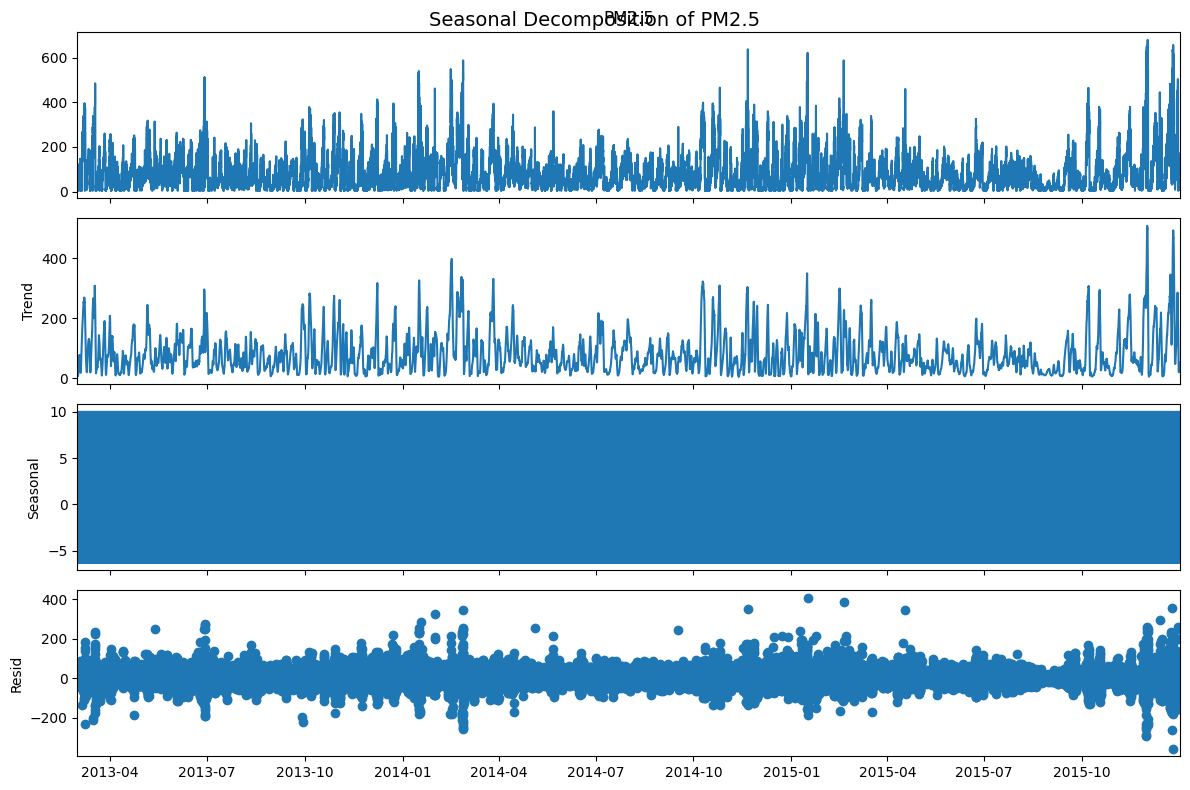

In [81]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Decompose with daily seasonality (~24 hours)
decomp = seasonal_decompose(train['PM2.5'], model='additive', period=24)

plt.rcParams.update({'figure.figsize': (12,8)})
decomp.plot()
plt.suptitle("Seasonal Decomposition of PM2.5", fontsize=14)
plt.show()


### Autocorrelation plots (ACF & PACF)

<Figure size 1000x400 with 0 Axes>

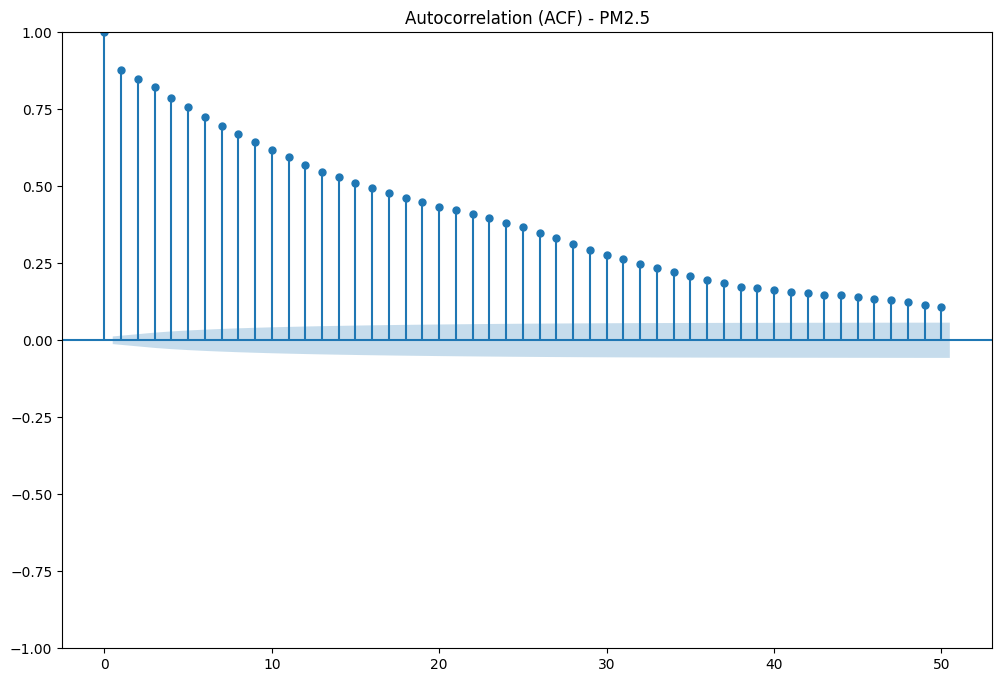

<Figure size 1000x400 with 0 Axes>

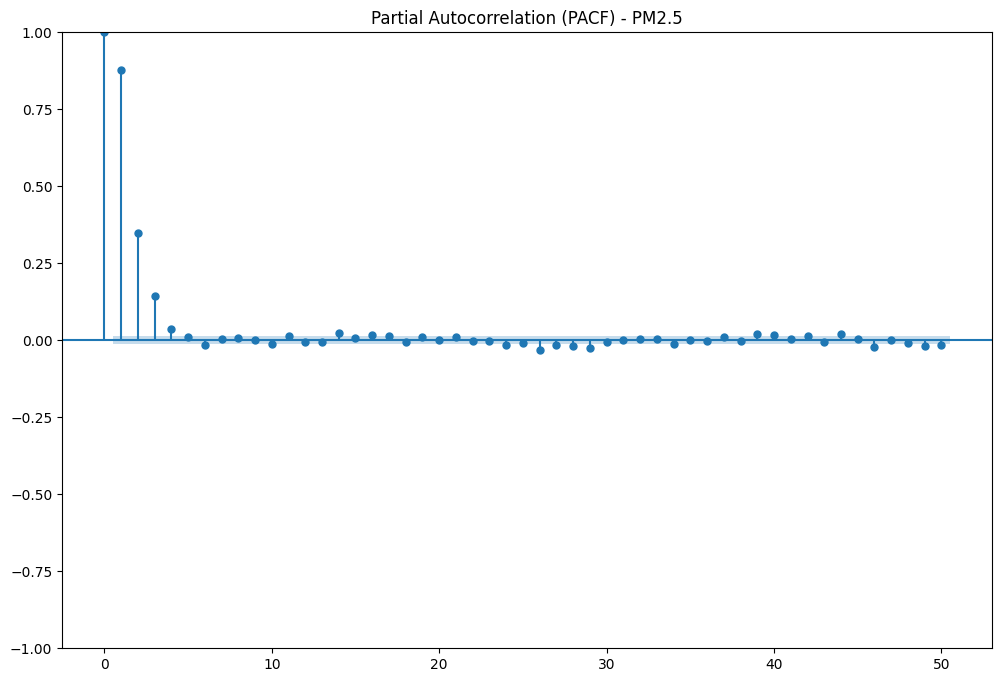

In [82]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF plot
plt.figure(figsize=(10,4))
plot_acf(train['PM2.5'], lags=50)
plt.title("Autocorrelation (ACF) - PM2.5")
plt.show()

# PACF plot
plt.figure(figsize=(10,4))
plot_pacf(train['PM2.5'], lags=50, method='ywm')
plt.title("Partial Autocorrelation (PACF) - PM2.5")
plt.show()


### ARIMA Modeling

In [83]:
from statsmodels.tsa.arima.model import ARIMA

# Define train/test target 
y_train = train['PM2.5']
y_test  = test['PM2.5']

# Define ARIMA model (example order, update after ACF/PACF)
arima_model = ARIMA(y_train, order=(1,1,1))   # p=1, d=1, q=1
arima_fit = arima_model.fit()

# Print summary(coefficients, AIC/BIC)
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                24862
Model:                 ARIMA(1, 1, 1)   Log Likelihood             -124366.218
Date:                Thu, 02 Oct 2025   AIC                         248738.436
Time:                        01:52:43   BIC                         248762.799
Sample:                    03-01-2013   HQIC                        248746.323
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0351      0.006     -6.183      0.000      -0.046      -0.024
ma.L1         -0.4300      0.006    -75.689      0.000      -0.441      -0.419
sigma2      1297.9433      3.720    348.932      0.0

In [84]:
# Forecast on test set
arima_forecast = arima_fit.forecast(steps=len(y_test))

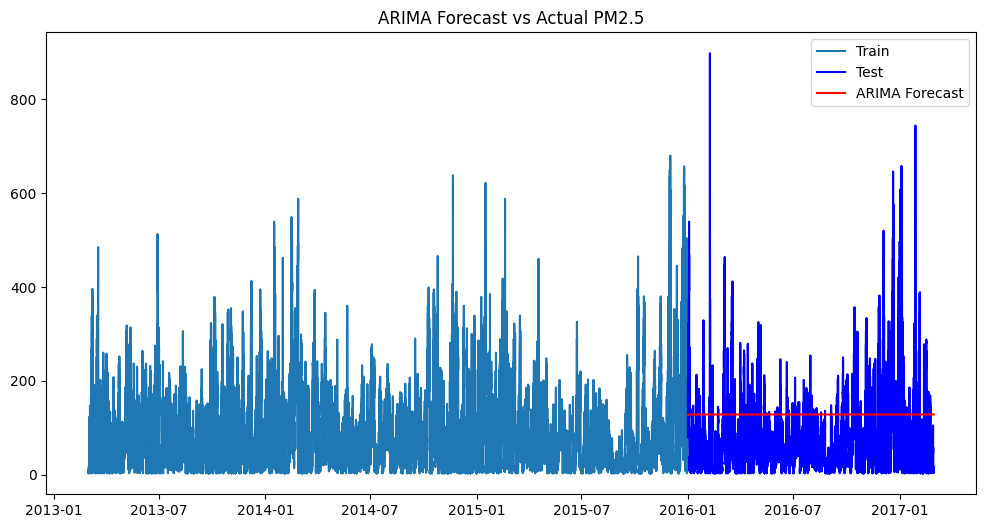

In [85]:
# Plot actual vs forecast
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(y_test.index, y_test, label="Test", color="blue")
plt.plot(y_test.index, arima_forecast, label="ARIMA Forecast", color="red")
plt.legend()
plt.title("ARIMA Forecast vs Actual PM2.5")
plt.show()

### Evaluation

In [86]:
#  Evaluation 
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse  = mean_squared_error(y_test, arima_forecast)
mae  = mean_absolute_error(y_test, arima_forecast)
rmse = np.sqrt(mse)

print("ARIMA Evaluation")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

ARIMA Evaluation
MAE: 84.62
MSE: 9612.94
RMSE: 98.05


### SARIMA Modeling

 SARIMA model without exogenous variables

                                     SARIMAX Results                                      
Dep. Variable:                       D.DS30.PM2.5   No. Observations:                24831
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 30)   Log Likelihood             -124158.869
Date:                            Thu, 02 Oct 2025   AIC                         248327.739
Time:                                    01:53:42   BIC                         248368.331
Sample:                                03-02-2013   HQIC                        248340.882
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0365      0.006     -6.407      0.000      -0.048      -0.025
ma.L1         -0.4290      0.006   

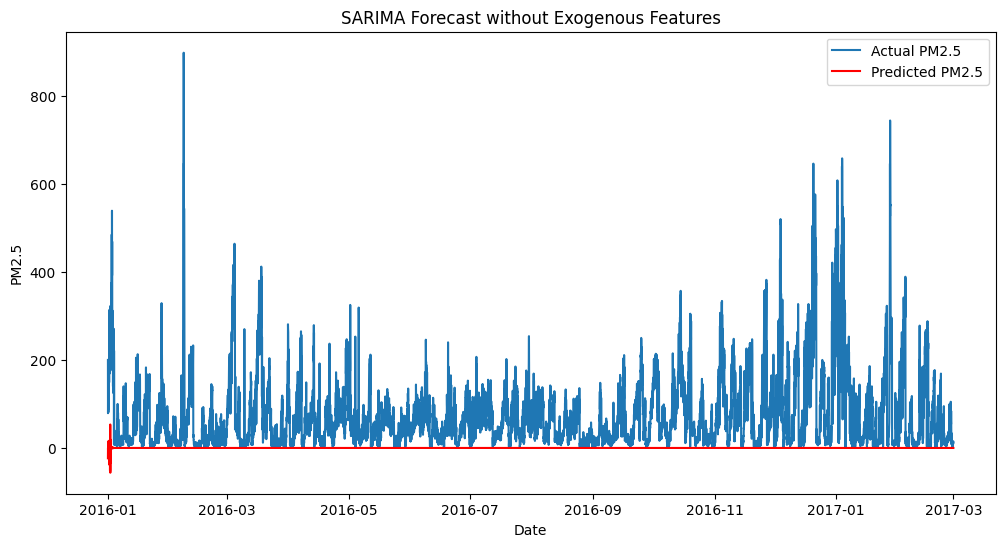

In [87]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define train/test target
y_train = train['PM2.5']
y_test  = test['PM2.5']

# SARIMA model without exogenous variables
# Example: ARIMA(1,1,1) with seasonal (1,1,1,30)
sarima_model = SARIMAX(
    endog=y_train,
    order=(1, 1, 1),           # ARIMA part (p,d,q)
    seasonal_order=(1, 1, 1, 30),  # Seasonal part (P,D,Q,s)
    enforce_stationarity=False,
    enforce_invertibility=False,
    simple_differencing=True
)

# Fit the model
sarima_results = sarima_model.fit(disp=False)

# Summary statistics
print(sarima_results.summary())

# Forecast for test period
y_pred = sarima_results.predict(start=y_test.index[0], end=y_test.index[-1])

# visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual PM2.5')
plt.plot(y_test.index, y_pred, label='Predicted PM2.5', color='red')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.title('SARIMA Forecast without Exogenous Features')
plt.legend()
plt.show()


In [88]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate metrics
mae_sarima = mean_absolute_error(y_test, y_pred)
rmse_sarima = np.sqrt(mean_squared_error(y_test, y_pred))

print("SARIMA (no exogenous features) Evaluation")
print(f"MAE: {mae_sarima:.2f}")
print(f"RMSE: {rmse_sarima:.2f}")


SARIMA (no exogenous features) Evaluation
MAE: 74.82
RMSE: 111.16


 SARIMA model with exogenous variables

In [89]:
#  Resample if dataset is too large
if len(y_train) > 100000:
    y_train = y_train.resample('D').mean()
    y_test = y_test.resample('D').mean()
    X_train = X_train.resample('D').mean()
    X_test = X_test.resample('D').mean()

In [90]:
# order = (p, d, q), seasonal_order = (P, D, Q, s)
# Assuming monthly seasonality on daily data (s=30)
sarimax_model = SARIMAX(
    endog=y_train,        # target
    exog=X_train,         # exogenous features
    order=(1, 1, 1),      # ARIMA part (p,d,q)
    seasonal_order=(1, 1, 1, 30), # Seasonality (P,D,Q,s)
    enforce_stationarity=False,
    enforce_invertibility=False,
    simple_differencing=True    # speeds up fitting
)

#  Fit the model
sarima_results = sarimax_model.fit(disp=False)

#summary statistics
print(sarima_results.summary())
     

                                     SARIMAX Results                                      
Dep. Variable:                       D.DS30.PM2.5   No. Observations:                24831
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 30)   Log Likelihood             -113131.642
Date:                            Thu, 02 Oct 2025   AIC                         226313.283
Time:                                    02:01:19   BIC                         226516.247
Sample:                                03-02-2013   HQIC                        226379.002
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
PM10                0.3247      0.002    161.215      0.000       0.321       0.329
SO2                 

In [91]:
# Forecast
sarima_forecast = sarima_results.get_forecast(steps=len(y_test), exog=X_test)
sarima_pred = sarima_forecast.predicted_mean

In [92]:
#  Extract predicted mean and confidence intervals
y_pred = sarima_forecast.predicted_mean
conf_int = sarima_forecast.conf_int()

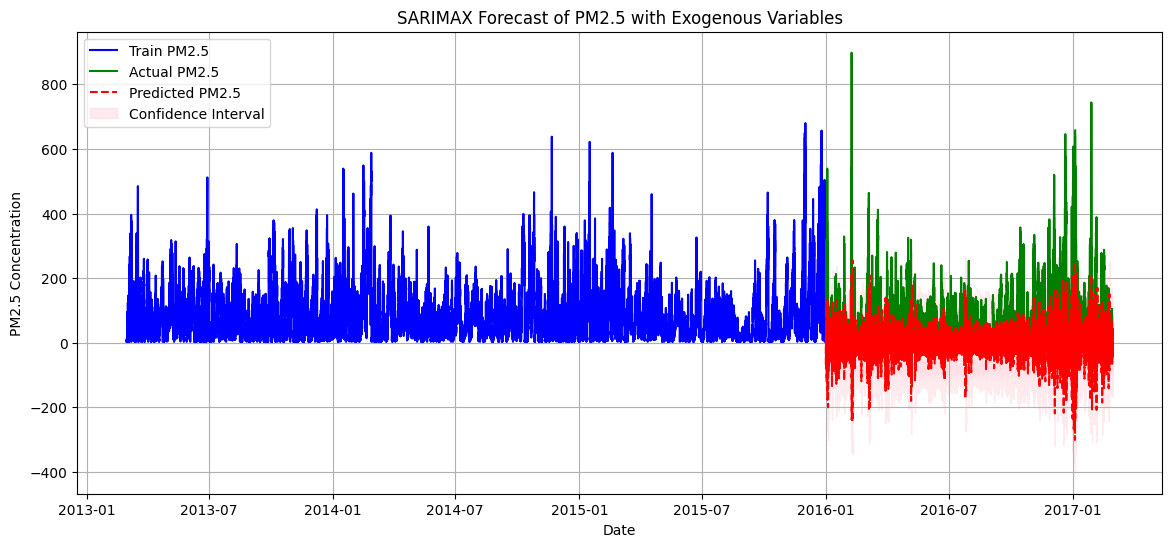

In [93]:
#  Visualization
plt.figure(figsize=(14,6))
plt.plot(y_train.index, y_train, label="Train PM2.5", color="blue")
plt.plot(y_test.index, y_test, label="Actual PM2.5", color="green")
plt.plot(y_test.index, y_pred, label="Predicted PM2.5", color="red", linestyle="dashed")

# Plot confidence interval shading
plt.fill_between(y_test.index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3, label="Confidence Interval")

plt.xlabel("Date")
plt.ylabel("PM2.5 Concentration")
plt.title("SARIMAX Forecast of PM2.5 with Exogenous Variables")
plt.legend()
plt.grid(True)
plt.show()

Forecast: Uses get_forecast() with X_test (exogenous vars).

Predictions: Extracts predicted_mean.

Confidence Interval: Shades the 95% confidence range → very useful in air quality forecasting.

### Evaluation

In [94]:
#  Evaluation (optional, if not already done)
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("SARIMAX Evaluation")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

SARIMAX Evaluation
MAE:  78.40
MSE:  12993.46
RMSE: 113.99


###  Hyperparameter Tuning using a manual grid search method

In [95]:
import warnings
import itertools
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import random

def find_best_sarimax_fast(y_train, X_train=None, 
                           p_range=range(0,2), d_range=range(0,2), q_range=range(0,2),
                           P_range=range(0,2), D_range=range(0,2), Q_range=range(0,2),
                           s_values=[24, 30],
                           n_iter=30):  # number of random combinations to try
    """
    Fast SARIMAX tuning using randomized search based on AIC.
    Returns best_order, best_seasonal_order, best_model, best_aic.
    """
    pdq = list(itertools.product(p_range, d_range, q_range))
    seasonal_pdq = list(itertools.product(P_range, D_range, Q_range, s_values))

    # Generate all combinations
    all_combinations = list(itertools.product(pdq, seasonal_pdq))
    
    # Randomly sample n_iter combinations
    sampled_combinations = random.sample(all_combinations, min(n_iter, len(all_combinations)))

    best_aic = np.inf
    best_order = None
    best_seasonal = None
    best_model = None

    warnings.filterwarnings("ignore")

    for order, seasonal in sampled_combinations:
        try:
            model = SARIMAX(
                endog=y_train,
                exog=X_train,
                order=order,
                seasonal_order=seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False,
                simple_differencing=True
            )
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal = seasonal
                best_model = results
            print(f"Checked SARIMAX{order}x{seasonal} - AIC: {results.aic:.2f}")
        except Exception as e:
            print(f"SARIMAX{order}x{seasonal} failed: {e}")
            continue

    return best_order, best_seasonal, best_model, best_aic


In [96]:
best_order, best_seasonal, best_model, best_aic = find_best_sarimax_fast(y_train, X_train)
print("Best SARIMAX Model")
print(f"Order: {best_order}")
print(f"Seasonal Order: {best_seasonal}")
print(f"AIC: {best_aic:.2f}")


Checked SARIMAX(0, 1, 0)x(1, 1, 1, 24) - AIC: 231407.35
Checked SARIMAX(1, 0, 0)x(0, 0, 0, 30) - AIC: 222749.13
Checked SARIMAX(0, 1, 0)x(0, 1, 0, 24) - AIC: 248889.29
Checked SARIMAX(1, 1, 0)x(0, 1, 1, 30) - AIC: 223907.83
Checked SARIMAX(1, 1, 1)x(1, 0, 0, 24) - AIC: 221049.64
Checked SARIMAX(1, 1, 1)x(0, 0, 0, 30) - AIC: 221232.08
Checked SARIMAX(1, 1, 0)x(1, 1, 1, 30) - AIC: 225086.77
Checked SARIMAX(1, 1, 1)x(1, 1, 0, 24) - AIC: 231704.51
Checked SARIMAX(0, 0, 1)x(1, 1, 1, 30) - AIC: 227249.81
Checked SARIMAX(0, 1, 1)x(0, 1, 1, 24) - AIC: 223608.07
Checked SARIMAX(0, 0, 0)x(0, 0, 1, 24) - AIC: 225047.42
Checked SARIMAX(0, 1, 0)x(1, 1, 0, 30) - AIC: 241103.26
Checked SARIMAX(1, 1, 1)x(0, 1, 0, 24) - AIC: 238186.70
Checked SARIMAX(1, 1, 1)x(0, 0, 0, 24) - AIC: 221232.08
Checked SARIMAX(0, 0, 0)x(0, 0, 0, 24) - AIC: 226252.55
Checked SARIMAX(1, 1, 1)x(1, 0, 1, 30) - AIC: 220999.39
Checked SARIMAX(1, 0, 0)x(0, 0, 0, 24) - AIC: 222749.13
Checked SARIMAX(0, 0, 0)x(0, 1, 0, 30) - AIC: 24

### Refit SARIMAX with Best Parameters

In [97]:
# Refit the SARIMAX model using the best parameters
refit_model = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
)

refit_results = refit_model.fit(disp=False)
print(refit_results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                              PM2.5   No. Observations:                24862
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 30)   Log Likelihood             -110474.036
Date:                            Thu, 02 Oct 2025   AIC                         220998.072
Time:                                    04:10:03   BIC                         221201.067
Sample:                                03-01-2013   HQIC                        221063.797
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
PM10                0.3291      0.001    316.922      0.000       0.327       0.331
SO2                 

### Forecast Future Values

In [99]:
# Forecast for the test set length
y_pred = refit_results.get_forecast(steps=len(y_test), exog=X_test).predicted_mean


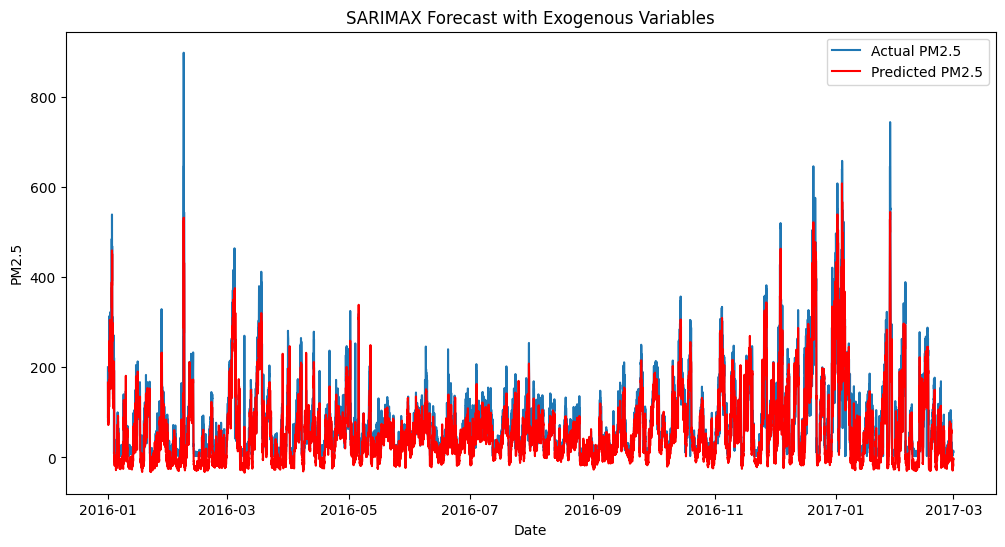

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Actual PM2.5")
plt.plot(y_test.index, y_pred, label="Predicted PM2.5", color="red")
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.title("SARIMAX Forecast with Exogenous Variables")
plt.legend()
plt.show()


In [101]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Compute Improved RMSE
improved_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Compute Improved MAE
improved_mae = mean_absolute_error(y_test, y_pred)

print(f"Improved RMSE: {improved_rmse:.2f}")
print(f"Improved MAE: {improved_mae:.2f}")


Improved RMSE: 27.20
Improved MAE: 21.04
